In [1]:
#pip install pandas matplotlib scipy numpy seaborn natsort

In [2]:
import copy
import pandas
import warnings
import requests
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import json
import os
import sys

sys.path.insert(0, "../src")
from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

/home/mark/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [32]:
VARIANTS = {"replset": "linux-1-node-replSet-fle.2022-11", "sharded": "linux-shard-lite-qebench"}

# WORKDIR="../datasets/genny2/perf1"
# patch_id = "639aa0d661837d305582a2f7"

#WORKDIR="../datasets/genny2/fle_perf_get_tags"
#patch_id = "63bf6117c9ec4415c9ae5a9e"

# WORKDIR="../datasets/genny2/fle_no_emu"
# patch_id = "63c884213066151c43946bdb"

# WORKDIR="../datasets/genny2/fle_perf_stack"
# patch_id = "63cf74cd1e2d177cc4ba0ea4"


# WORKDIR="../datasets/genny2/fle_perf_stack2"
# patch_id = "63d758617742ae68d632fa85"

# WORKDIR="../datasets/genny2/fle_perf_stack2_txn_insert"
# patch_id = "63d82f7656234349d7341d45"

WORKDIR="../datasets/genny2/fle_perf_stack2_query_in"
patch_id = "63d8bac10305b9386711938d"

exec_idx=0

In [38]:

EXPERIMENTS = [
  # {
  #   # Experiment Set q.1: Query unencrypted fields on unencrypted collection
  #   "name" : "es1",
  #   "coll" : "pbl",
  #   "encryptedFieldCount" : 0,
  #   "threadCounts" : [1,4,8,16],
  #   #"contentionFactors" : [1,4,8,16],
  #   "contentionFactors" : [1],
  #   "queries" : [
  #     {
  #       "field" : "fixed_10",
  #       "value" : "fixed_hf"
  #     },
  #     {
  #       "field" : "fixed_10",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,10]",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,10]",
  #       "value" : "uar_alllow"
  #     },
  #   ]
  # },
  {
    # Experiment Set q.2: Query unencrypted fields on partially encrypted collection
    "name" : "es2",
    "coll" : "pbl",
    "encryptedFieldCount" : 5,
    "threadCounts" : [1,4,8,16],
    "contentionFactors" : [1,4,8,16],
    "queries" : [
      {
        "field" : "fixed_10",
        "value" : "fixed_hf"
      },
      {
        "field" : "fixed_10",
        "value" : "uar"
      },
      {
        "field" : "uar_[6,10]",
        "value" : "uar"
      },
      {
        "field" : "uar_[6,10]",
        "value" : "uar_alllow"
      },
      {
        "field" : "fixed_int",
        "value" : "int"
      },
        {
        "field" : "fixed_int",
        "value" : "int_txn"
      },
    ]
  },
  # {
  #   # Experiment Set q.3: Query encrypted fields on partially encrypted collection
  #   "name" : "es3",
  #   "coll" : "pbl",
  #   "encryptedFieldCount" : 5,
  #   "threadCounts" : [1,4,8,16],
  #   "contentionFactors" : [1,4,8,16],
  #   "queries" : [
  #     {
  #       "field" : "fixed_1",
  #       "value" : "fixed_hf"
  #     },
  #     {
  #       "field" : "fixed_1",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,5]",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,5]",
  #       "value" : "uar_alllow"
  #     },
  #   ]
  # },
  # {
  #   # Experiment Set q.4: Query encrypted fields on fully encrypted collection
  #   "name" : "es4",
  #   "coll" : "pbl",
  #   "encryptedFieldCount" : 10,
  #   "threadCounts" : [1,4,8,16],
  #   "contentionFactors" : [1,4,8,16],
  #   "queries" : [
  #     {
  #       "field" : "fixed_1",
  #       "value" : "fixed_hf"
  #     },
  #     {
  #       "field" : "fixed_1",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,10]",
  #       "value" : "uar"
  #     },
  #     {
  #       "field" : "uar_[1,10]",
  #       "value" : "uar_alllow"
  #     },
  #   ]
  # },
  # {
  #   # Experiment Set q.5: Check the impact of BSON limit on queries on both encrypted and unencrypted fields
  #   "name" : "es5",
  #   "coll" : "blimit",
  #   "encryptedFieldCount" : 5,
  #   "threadCounts" : [1,4,8,16],
  #   "contentionFactors" : [1,4,8,16],
  #   "queries" : [
  #     {
  #       "field" : "fixed_1",
  #       "value" : "fixed_hf"
  #     },
  #     {
  #       "field" : "fixed_10",
  #       "value" : "fixed_hf"
  #     },
  #   ]
  # },
]

In [40]:
class DataSetCache:
    def __init__(self, workdir, patch_id, variant, execution, task_name, experiment, cf, tc, query_num, query, phase_name):
        self.workdir = workdir
        self.patch_id = patch_id
        self.variant = variant
        self.execution = execution
        self.task_name = task_name
        self.experiment = experiment
        self.cf = cf
        self.tc = tc
        self.query_num = query_num
        self.phase_name = phase_name
        self.variant = variant

        self.query = query
        self.data = None

    def json_path(self, metric):
        return os.path.join(self.workdir, self.patch_id, self.variant,
            self.task_name, str(self.execution), metric + ".json")

    def get_data(self):
        if self.data is None:
            self.data = get_data(self.json_path("InsertActor." + self.phase_name))
        return self.data

DATASETS = {}

for ex in EXPERIMENTS:
    for cf in ex["contentionFactors"]:
        for tc in ex["threadCounts"]:
            experiment = ex['name']
            testName = f"query_{ex['name']}_{cf}_{tc}"
            fullName = testName + ".load"

            DATASETS[fullName] = DataSetCache(WORKDIR, patch_id, VARIANTS["replset"], "0", testName, experiment, cf, tc, "load", "load", "load.inserts")

            for i, query in enumerate(ex["queries"]):
                qi = i + 1
                fullName = testName + f".q{qi}.reads"

                if qi == 6:
                    DATASETS[fullName] = DataSetCache(WORKDIR, patch_id, VARIANTS["replset"], "0", testName, experiment, cf, tc, qi, f"{query['field']}: {query['value']}", f"q{qi}.7")

                else:
                    DATASETS[fullName] = DataSetCache(WORKDIR, patch_id, VARIANTS["replset"], "0", testName, experiment, cf, tc, qi, f"{query['field']}: {query['value']}", f"q{qi}.reads")


In [11]:
def get_load_datacache(experiment_name, cf, tc):
    ds_name = f"query_{experiment_name}_{cf}_{tc}.load"
    return DATASETS[ds_name]

def get_query_datacache(experiment_name, cf, tc, query_number):
    ds_name = f"query_{experiment_name}_{cf}_{tc}.q{query_number}.reads"
    return DATASETS[ds_name]

In [12]:
# Get summary statistics for all data sets
def get_summary_statistics_df(ds_cache):
    l1 = ds_cache.get_data()
    b = l1.diff_data
    fixed_data = l1.fixed_data
    raw_data = l1.raw_data

    quantiles = stats.mstats.mquantiles(b.loc[:,"pure_latency"].values, prob=[0.5,0.8,0.9,0.95,0.99], alphap=1/3, betap=1/3)
    averages = b.mean(numeric_only=True)
    maximum = b.max()
    minimum = b.min()
    duration = (b["ts"][len(b)-1] - b["ts"][0]).total_seconds()
    ops = fixed_data["d(ops)"].sum()
    size = fixed_data["d(size)"].sum()
    docs = fixed_data["d(n)"].sum()
    errs = fixed_data["d(err)"].sum()
    overhead = fixed_data["d(t_overhead)"].sum()

    df = pandas.DataFrame(index = [0], data = {
        'Task' : ds_cache.task_name + "." + ds_cache.phase_name,
        'TaskName' : ds_cache.task_name,
        'Experiment' : ds_cache.experiment,
        'Phase' : ds_cache.phase_name,
        'Query' : ds_cache.query,
        'QueryNumber' : ds_cache.query_num,
        'ContentionFactor': ds_cache.cf,
        'ThreadCount': ds_cache.tc,
        'AverageLatency': averages["pure_latency"],
        'AverageLatencyMillis': averages["pure_latency(ms)"],
        'AverageSize': size / ops,
        'OperationThroughput': ops / duration,
        'DocumentThroughput': docs / duration,
        'SizeThroughput': size / duration,
        'ErrorRate': errs / duration,
        'Latency50thPercentile': quantiles[0],
        'Latency80thPercentile': quantiles[1],
        'Latency90thPercentile': quantiles[2],
        'Latency95thPercentile': quantiles[3],
        'Latency99thPercentile': quantiles[4],
        'WorkersMin': raw_data["gauges.workers"].min(),
        'WorkersMax': raw_data["gauges.workers"].max(),
        'LatencyMax': maximum["pure_latency"],
        'LatencyMin': minimum["pure_latency"],
        'DurationTotal': duration * 1e9,
        'ErrorsTotal': errs,
        'OperationsTotal': ops,
        'DocumentsTotal': docs,
        'SizeTotal': size,
        'OverheadTotal': overhead
    })

    return df


array([[<AxesSubplot: title={'center': 'pure_latency(ms)'}>]],
      dtype=object)

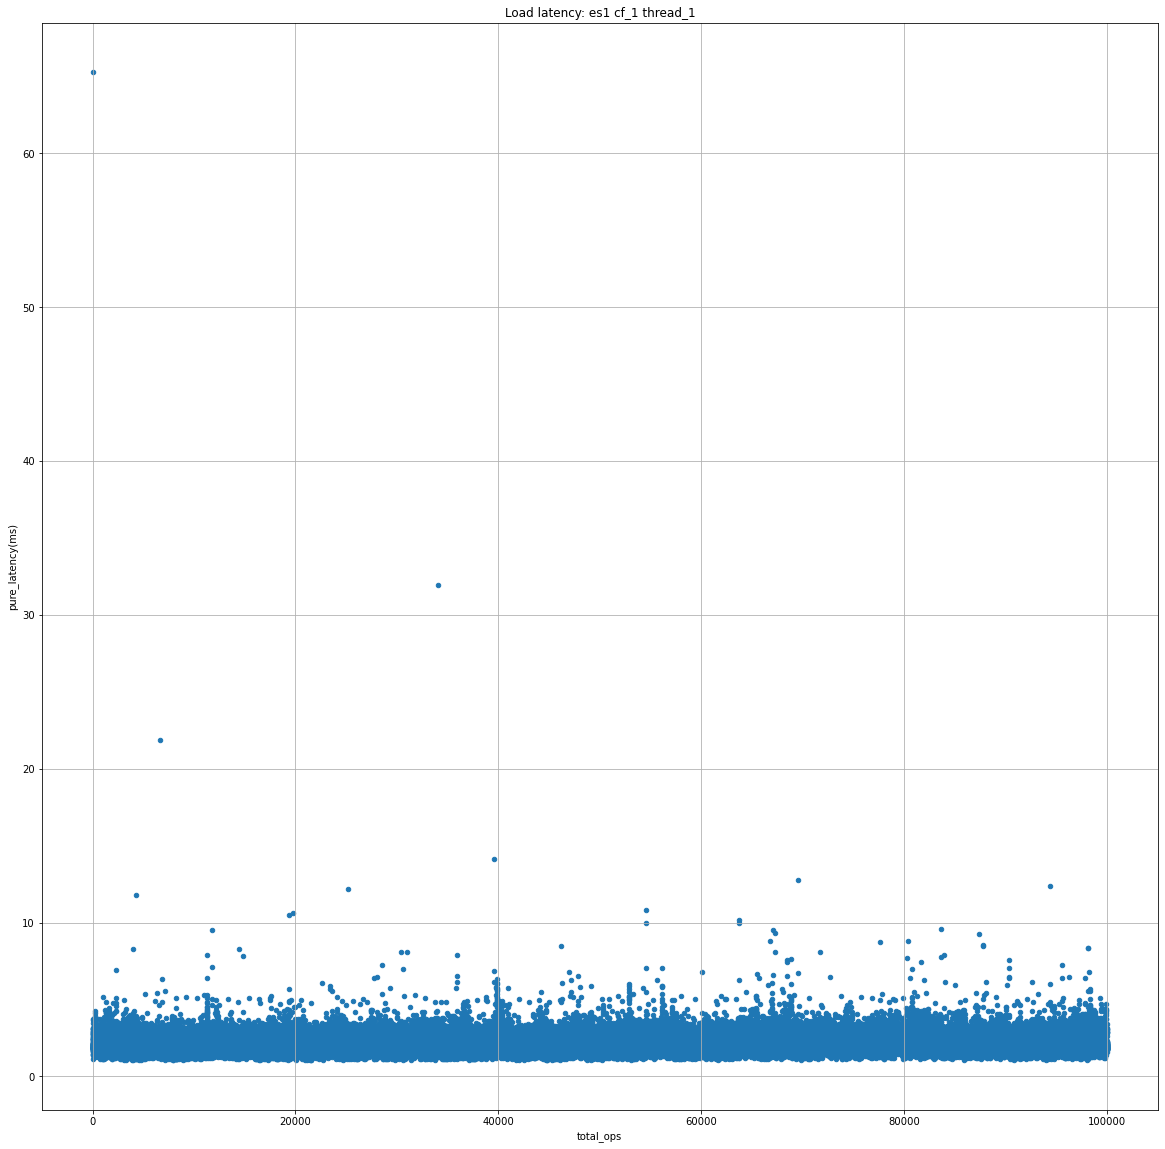

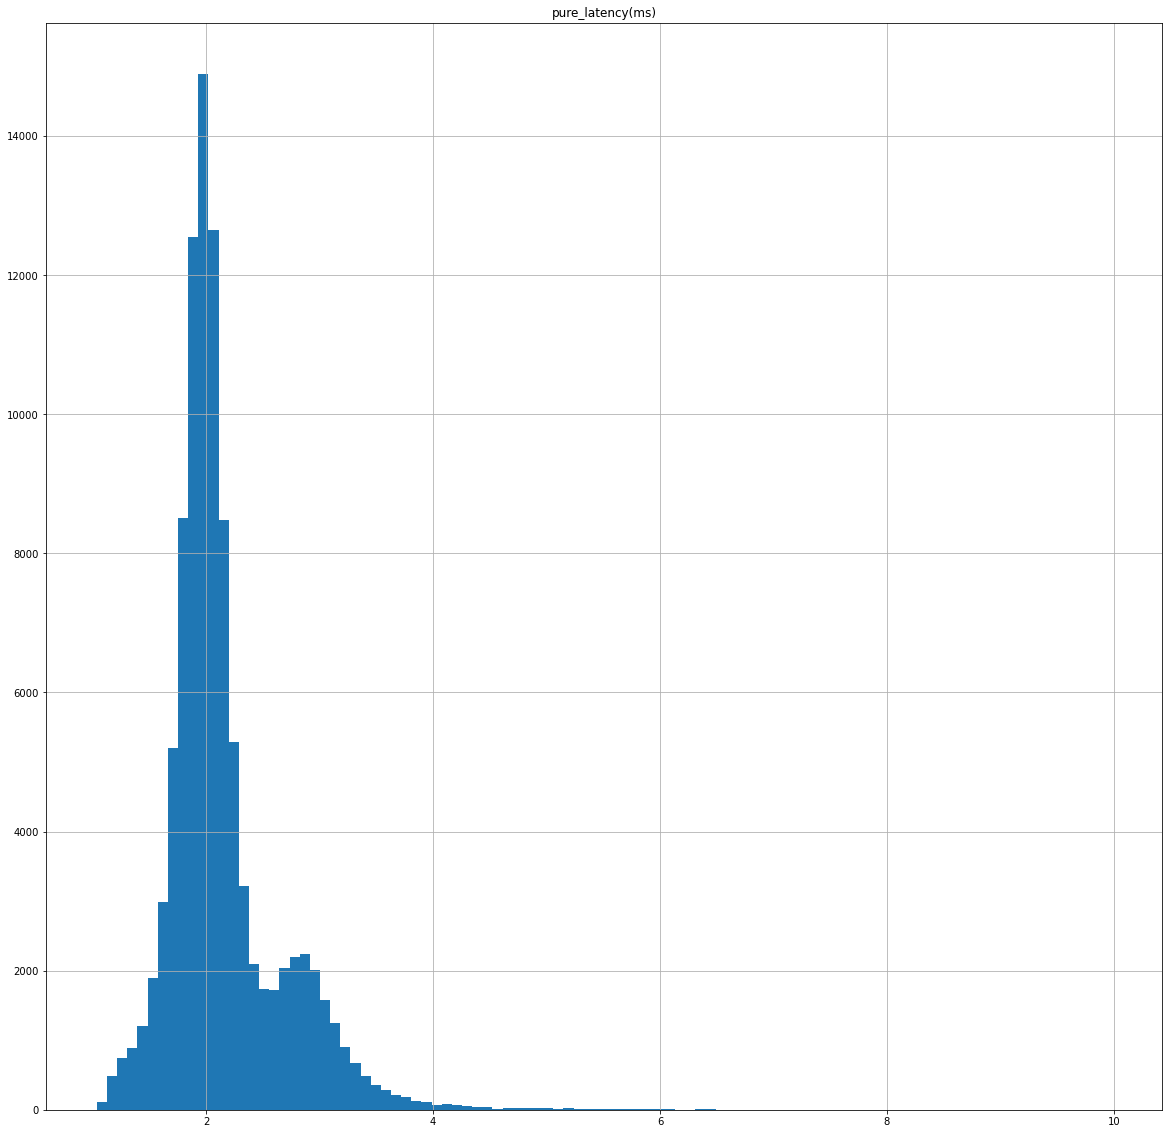

In [31]:
df = None


experiment = "es1"
cf = 1
tc = 1
testName = f"query_{experiment}_{cf}_{tc}"

# dc = DataSetCache(WORKDIR, patch_id, VARIANTS["replset"], "0", testName, experiment, cf, tc, "load", "load", "load.0")
dc = DataSetCache(WORKDIR, patch_id, VARIANTS["replset"], "0", testName, experiment, cf, tc, "load", "load", "load.inserts")


df = get_summary_statistics_df(dc)


# df.to_csv("/tmp/summary.csv")
df

df_w = dc.get_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: {experiment} cf_{cf} thread_{tc}", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
# plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)
df_h = df_w.query("`pure_latency(ms)` < 10")

df_h.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

In [41]:
# Generate summary.csv
# Get summary statistics for all data sets
# WARNING: may take several minutes
df = None

for key in DATASETS.keys():
    if df is None:
        df = get_summary_statistics_df(DATASETS[key])
    else:
        df = pandas.concat([df, get_summary_statistics_df(DATASETS[key])], ignore_index=True)

df.to_csv("/tmp/summary.csv")
df


,Task,TaskName,Experiment,Phase,Query,QueryNumber,ContentionFactor,ThreadCount,AverageLatency,AverageLatencyMillis,...,WorkersMin,WorkersMax,LatencyMax,LatencyMin,DurationTotal,ErrorsTotal,OperationsTotal,DocumentsTotal,SizeTotal,OverheadTotal
0,query_es2_1_1.load.inserts,query_es2_1_1,es2,load.inserts,load,load,1,1,3.633557e+06,3.633557,...,1,1,52955206.0,2210569.0,3.686330e+11,0.0,100000.0,100000.0,17446120.0,6.776634e+09
1,query_es2_1_1.q1.reads,query_es2_1_1,es2,q1.reads,fixed_10: fixed_hf,1,1,1,4.888261e+05,0.488826,...,1,1,792725.0,474729.0,5.227000e+09,0.0,10000.0,10000.0,3880000.0,3.708943e+11
2,query_es2_1_1.q2.reads,query_es2_1_1,es2,q2.reads,fixed_10: uar,2,1,1,6.546380e+06,6.546380,...,1,1,114827600.0,454298.0,6.612500e+10,0.0,10000.0,9343.0,3611233.0,3.764426e+11
3,query_es2_1_1.q3.reads,query_es2_1_1,es2,q3.reads,"uar_[6,10]: uar",3,1,1,6.257408e+06,6.257408,...,1,1,93391100.0,450311.0,6.306900e+10,0.0,10000.0,9368.0,3621092.0,4.422704e+11
4,query_es2_1_1.q4.reads,query_es2_1_1,es2,q4.reads,"uar_[6,10]: uar_alllow",4,1,1,6.948819e+06,6.948819,...,1,1,93000154.0,449745.0,6.991300e+10,0.0,10000.0,9290.0,3591627.0,5.047057e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,query_es2_16_16.q2.reads,query_es2_16_16,es2,q2.reads,fixed_10: uar,2,16,16,1.318336e+07,13.183358,...,16,16,283980622.0,471921.0,9.619000e+09,0.0,10000.0,9279.0,3587391.0,1.337477e+12
108,query_es2_16_16.q3.reads,query_es2_16_16,es2,q3.reads,"uar_[6,10]: uar",3,16,16,1.246500e+07,12.465004,...,16,16,250528443.0,463076.0,8.689000e+09,0.0,10000.0,9323.0,3604058.0,1.489024e+12
109,query_es2_16_16.q4.reads,query_es2_16_16,es2,q4.reads,"uar_[6,10]: uar_alllow",4,16,16,1.291988e+07,12.919878,...,16,16,272967513.0,460180.0,9.178999e+09,0.0,10000.0,9294.0,3593541.0,1.617128e+12
110,query_es2_16_16.q5.reads,query_es2_16_16,es2,q5.reads,fixed_int: int,5,16,16,6.913350e+06,6.913350,...,16,16,44725159.0,4367002.0,4.867200e+10,0.0,100000.0,100000.0,38000000.0,1.829405e+12


In [ ]:
# Graph latency for load for a given experiment
#
experiment = "es2"
cf = 1
tc = 8
e_datacache = get_load_datacache(experiment, cf, tc)
df_w = e_datacache.get_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: {experiment} cf_{cf} thread_{tc}", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)

array([[<AxesSubplot: title={'center': 'total_ops'}>]], dtype=object)

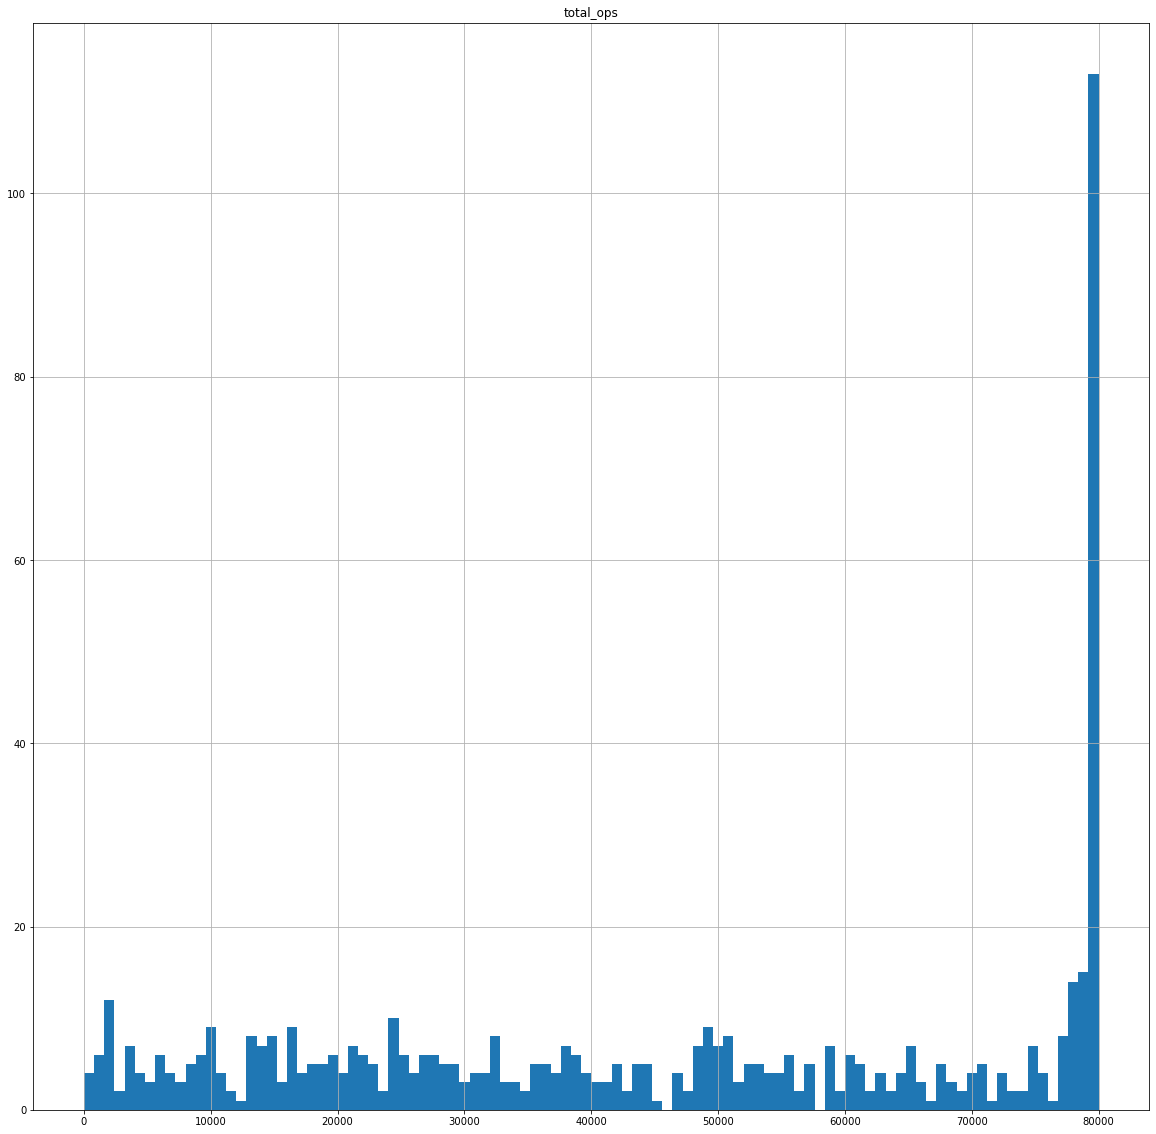

In [ ]:
# Graph histogram for a query for a given experiment
#
experiment = "es3"
cf = 1
tc = 8
e_datacache = get_query_datacache(experiment, cf, tc, "1")
df_w = e_datacache.get_data().diff_data

df_h = df_w.query("`pure_latency(ms)` < 50")
#df_h = df_w.query("`pure_latency(ms)` > 100")

#df_h = df_w
df_h

df_h.hist(figsize=(20,20), column= "total_ops", bins=100, grid=0.4)


array([[<AxesSubplot: title={'center': 'pure_latency(ms)'}>]],
      dtype=object)

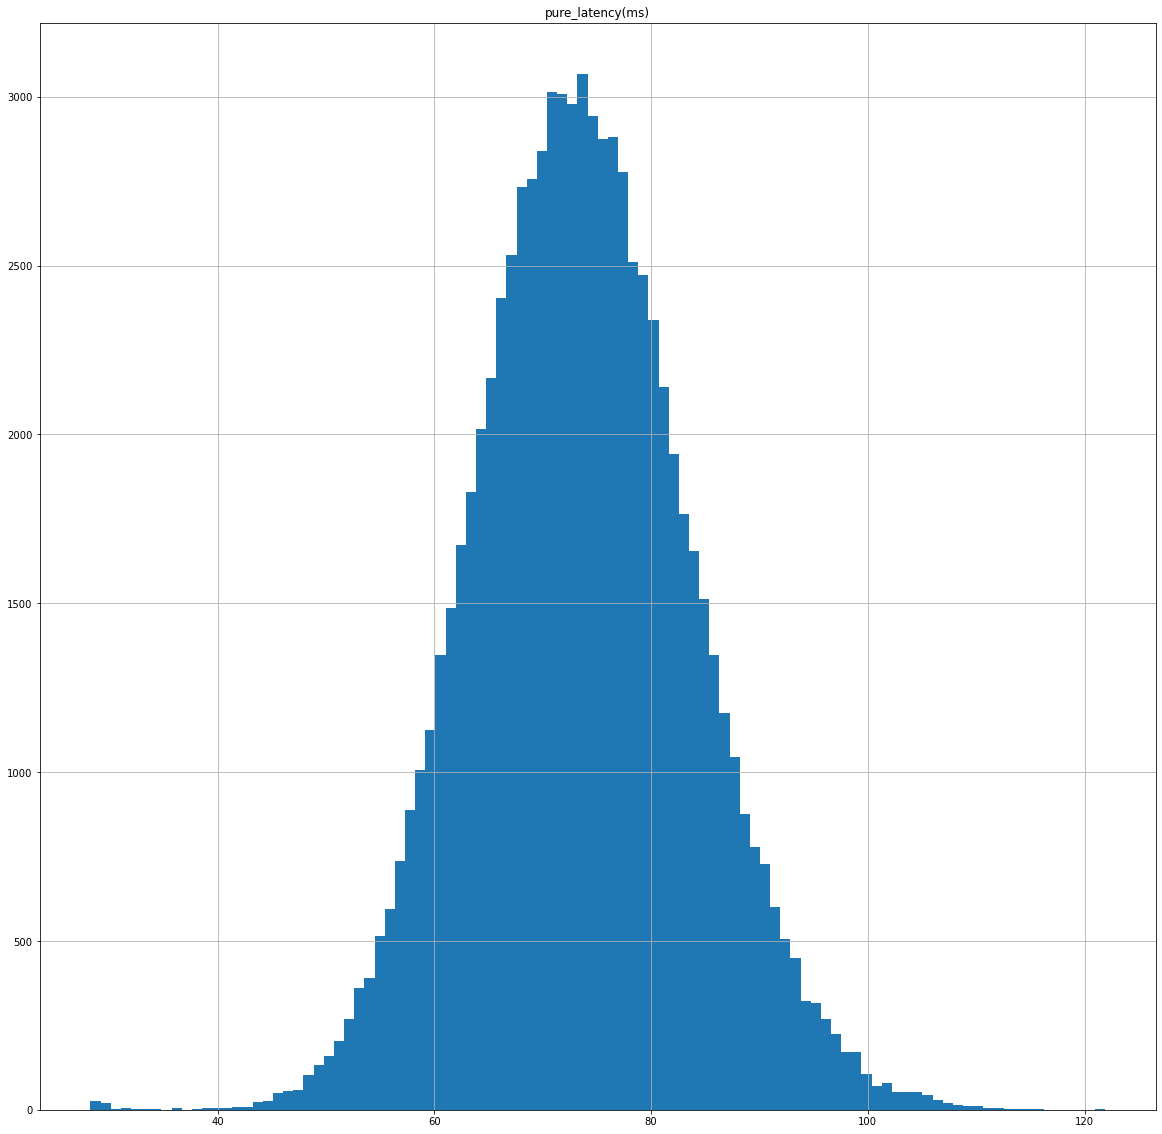

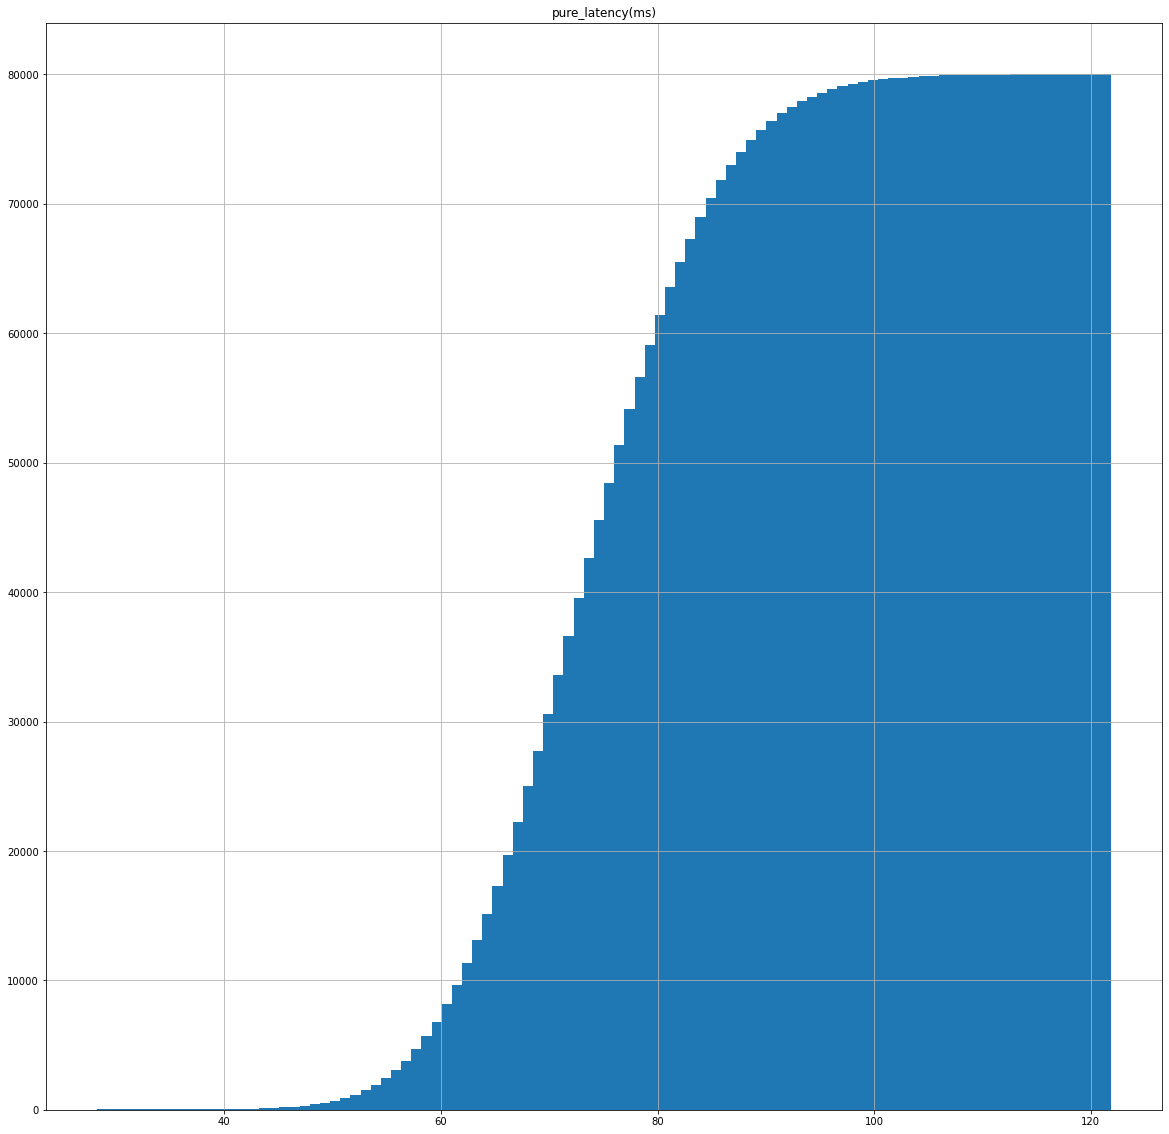

In [ ]:
# Graph histogram for a query for a given experiment
#
experiment = "es3"
cf = 1
tc = 8
e_datacache = get_query_datacache(experiment, cf, tc, "1")
df_w = e_datacache.get_data().diff_data

# Graph scatter plot of latency
#df_w.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, title=f"Load latency: {experiment} cf_{cf} thread_{tc}", ylabel="pure_latency(ms)", grid=0.4)
# df_h = df_w.query("`pure_latency(ms)` < 10000")
df_h = df_w

df_h.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

df_h.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4, cumulative=True)


In [ ]:
# Graph latency for query for a given experiment
#
experiment = "es2"
cf = 1
tc = 8
e_datacache = get_query_datacache(experiment, cf, tc, 1)
df_w = e_datacache.get_data().diff_data

# Graph scatter plot of latency
df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"Load latency: {experiment} cf_{cf} thread_{tc}", ylabel="pure_latency(ms)", grid=0.4)

# Graph latency with trend lines
plot_latency_stats(df_w, "total_ops", title=f"{experiment} cf_{cf} thread_{tc} insert stats", regr="log", start=start, end=end)

In [ ]:
# Graph throughput for given load experiment pivoted on thread count
experiment = "es1"
cf = 1
threadCounts = [1,4,8,16]
columns = []
column_data = []

for tc in threadCounts:
    
   
    e_datacache = get_load_datacache(experiment, cf, tc)
    df_w = e_datacache.get_data().diff_data
    
    name = f"cf_{cf}_thread_{tc}_throughput"
    column_data.append(df_w["throughput"])
    columns.append(name)
    print(name)
        
df = pandas.concat(column_data, axis="columns")
df.columns =columns
df[100:].plot(figsize=(20,20), title=f"Load throughput {experiment}", ylabel="throughput (ops/sec)", grid=0.4)

    

In [ ]:
# Graph throughput for given query experiment pivoted on thread count and contention factor
def plot_throughput_set(experiment, query_number, contentionFactors, threadCounts):
    columns = []
    column_data = []

    for cf in contentionFactors:
        for tc in threadCounts:
            e_datacache = get_query_datacache(experiment, cf, tc, query_number)
            df_w = e_datacache.get_data().diff_data
            
            name = f"cf_{cf}_thread_{tc}_throughput"
            column_data.append(df_w["throughput"])
            columns.append(name)
                
    df = pandas.concat(column_data, axis="columns")
    df.columns =columns
    df[100:].plot(figsize=(20,20), title=f"Read throughput {experiment} Query {query_number}", ylabel="throughput (ops/sec)", grid=0.4)

plot_throughput_set("es2", 1, [1,4,8,16], [1,4,8,16])
    

In [ ]:
experiment = "query_es2"
contentionFactors = [1]
threadCounts = [1,4,8,16]

es_workloads = {}
for cf in contentionFactors:
    
    columns = []
    column_data = []
    for tc in threadCounts:
        e_w = ES1Workload(WORKDIR, patch_id, VARIANTS["replset"], "0", f"{experiment}_{cf}_{tc}")
        es_workloads[(cf,tc)] = e_w
        df_w = e_w.get_load_data().diff_data
        
        name = f"cf_{cf}_thread_{tc}_throughput"
        column_data.append(df_w["throughput"])
        columns.append(name)
        print(name)
        
    df = pandas.concat(column_data, axis="columns")
    df.columns =columns
    print(df.columns)
    print(df.info())
    print(df.axes)
    #df.head()
    df.plot(figsize=(20,20), title="Load throughput", ylabel="throughput (ops/sec)", grid=0.4)
    